# Visualizing Website Topics (Claude + Firecrawl + E2B)

**Powered by [Claude 3.5 Sonnet](https://www.anthropic.com/news/claude-3-5-sonnet), [Firecrawl](https://www.firecrawl.dev/), and [Code Interpreter SDK](https://github.com/e2b-dev/code-interpreter) by [E2B](https://e2b.dev/docs)**

Scrape a website with Firecrawl and then plot the most common topics using Claude and Code Interpreter


In [ ]:
%pip install e2b_code_interpreter anthropic firecrawl-py 

In [1]:
import os
import datetime
import time
from firecrawl import FirecrawlApp
import json

# TODO: Get your Anthropic API key from https://anthropic.com
anthropic_api_key = "your-anthropic-api-key"
# TODO: Get your Firecrawl API key from https://www.firecrawl.dev
firecrawl_api_key = "your-firecrawl-api-key"
# TODO: Get your E2B API key from https://e2b.dev/docs
e2b_api_key = "your-e2b-api-key"

In [3]:
# Initialize the FirecrawlApp with your API key
app = FirecrawlApp(api_key=firecrawl_api_key)

# Crawl a website
crawl_url = 'https://python.langchain.com/v0.2/docs'
params = {
    'crawlerOptions': {
        'limit': 5
    }
}
crawl_result = app.crawl_url(crawl_url, params=params)
cleaned_crawl_result = []
if crawl_result is not None:
    # Convert crawl results to JSON format, excluding 'content' field from each entry
    cleaned_crawl_result = [{k: v for k, v in entry.items() if k != 'content'} for entry in crawl_result]
else:
    print("No data returned from crawl.")

[{'content': '[Skip to main content](#__docusaurus_skipToContent_fallback)\n\nLangChain 0.2 is out! Leave feedback on the v0.2 docs [here](https://github.com/langchain-ai/langchain/discussions/21716)\n. You can view the v0.1 docs [here](/v0.1/docs/get_started/introduction/)\n.\n\n[![🦜️🔗 LangChain](https://python.langchain.com/v0.2/img/brand/wordmark.png)![🦜️🔗 LangChain](https://python.langchain.com/v0.2/img/brand/wordmark-dark.png)](/v0.2/)\n[Integrations](/v0.2/docs/integrations/platforms/)\n[API Reference](https://api.python.langchain.com)\n\n[More](#)\n\n*   [People](/v0.2/docs/people/)\n    \n*   [Contributing](/v0.2/docs/contributing/)\n    \n*   [Templates](/v0.2/docs/templates/)\n    \n*   [Cookbooks](https://github.com/langchain-ai/langchain/blob/master/cookbook/README.md)\n    \n*   [3rd party tutorials](/v0.2/docs/additional_resources/tutorials/)\n    \n*   [YouTube](/v0.2/docs/additional_resources/youtube/)\n    \n*   [arXiv](/v0.2/docs/additional_resources/arxiv_references/

In [4]:
MODEL_NAME = "claude-3-5-sonnet-20240620"

SYSTEM_PROMPT = """
## your job & context
you are a python data scientist. you are given tasks to complete and you run python code to solve them.
- the python code runs in jupyter notebook.
- every time you call `execute_python` tool, the python code is executed in a separate cell. it's okay to multiple calls to `execute_python`.
- display visualizations using matplotlib or any other visualization library directly in the notebook. don't worry about saving the visualizations to a file.
- you have access to the internet and can make api requests.
- you also have access to the filesystem and can read/write files.
- you can install any pip package (if it exists) if you need to but the usual packages for data analysis are already preinstalled.
- you can run any python code you want, everything is running in a secure sandbox environment.

## style guide
tool response values that have text inside "[]"  mean that a visual element got rended in the notebook. for example:
- "[chart]" means that a chart was generated in the notebook.
"""

tools = [
    {
        "name": "execute_python",
        "description": "Execute python code in a Jupyter notebook cell and returns any result, stdout, stderr, display_data, and error.",
        "input_schema": {
            "type": "object",
            "properties": {
                "code": {
                    "type": "string",
                    "description": "The python code to execute in a single cell."
                }
            },
            "required": ["code"]
        }
    }
]

In [5]:
def code_interpret(e2b_code_interpreter, code):
  print("Running code interpreter...")
  exec = e2b_code_interpreter.notebook.exec_cell(
    code,
    on_stderr=lambda stderr: print("[Code Interpreter]", stderr),
    on_stdout=lambda stdout: print("[Code Interpreter]", stdout),
    # You can also stream code execution results
    # on_result=...
  )

  if exec.error:
    print("[Code Interpreter ERROR]", exec.error)
  else:
    return exec.results

In [6]:
from anthropic import Anthropic
client = Anthropic(
    api_key=anthropic_api_key,
)

def process_tool_call(e2b_code_interpreter, tool_name, tool_input):
    if tool_name == "execute_python":
        return code_interpret(e2b_code_interpreter, tool_input["code"])
    return []

def chat_with_claude(e2b_code_interpreter, user_message):
    print(f"\n{'='*50}\nUser Message: {user_message}\n{'='*50}")

    message = client.messages.create(
        model=MODEL_NAME,
        system=SYSTEM_PROMPT,
        messages=[{"role": "user", "content": user_message}],
        max_tokens=4096,
        tools=tools,
    )

    print(f"\nInitial Response:")
    print(f"Stop Reason: {message.stop_reason}")
    print(f"Content: {message.content}")

    if message.stop_reason == "tool_use":
        tool_use = next(block for block in message.content if block.type == "tool_use")
        tool_name = tool_use.name
        tool_input = tool_use.input

        print(f"\nTool Used: {tool_name}")
        print(f"Tool Input: {tool_input}")

        code_interpreter_results = process_tool_call(e2b_code_interpreter, tool_name, tool_input)

        print(f"Tool Result: {code_interpreter_results}")
        return code_interpreter_results
     



In [14]:
from e2b_code_interpreter import CodeInterpreter

with CodeInterpreter(api_key=e2b_api_key) as code_interpreter:
  code_interpreter_results = chat_with_claude(
    code_interpreter,
    "Use python to identify the most common topics in the crawl results. For each topic, count the number of times it appears in the crawl results and plot them. Here is the crawl results: " + str(cleaned_crawl_result),
  )
print(code_interpreter_results)


User Message: Use python to identify the most common topics in the crawl results. For each topic, count the number of times it appears in the crawl results and plot them. Here is the crawl results: [{'markdown': '[Skip to main content](#__docusaurus_skipToContent_fallback)\n\nLangChain 0.2 is out! Leave feedback on the v0.2 docs [here](https://github.com/langchain-ai/langchain/discussions/21716)\n. You can view the v0.1 docs [here](/v0.1/docs/get_started/introduction/)\n.\n\n[![🦜️🔗 LangChain](https://python.langchain.com/v0.2/img/brand/wordmark.png)![🦜️🔗 LangChain](https://python.langchain.com/v0.2/img/brand/wordmark-dark.png)](/v0.2/)\n[Integrations](/v0.2/docs/integrations/platforms/)\n[API Reference](https://api.python.langchain.com)\n\n[More](#)\n\n*   [People](/v0.2/docs/people/)\n    \n*   [Contributing](/v0.2/docs/contributing/)\n    \n*   [Templates](/v0.2/docs/templates/)\n    \n*   [Cookbooks](https://github.com/langchain-ai/langchain/blob/master/cookbook/README.md)\n    \n*

<Figure size 1200x600 with 1 Axes>


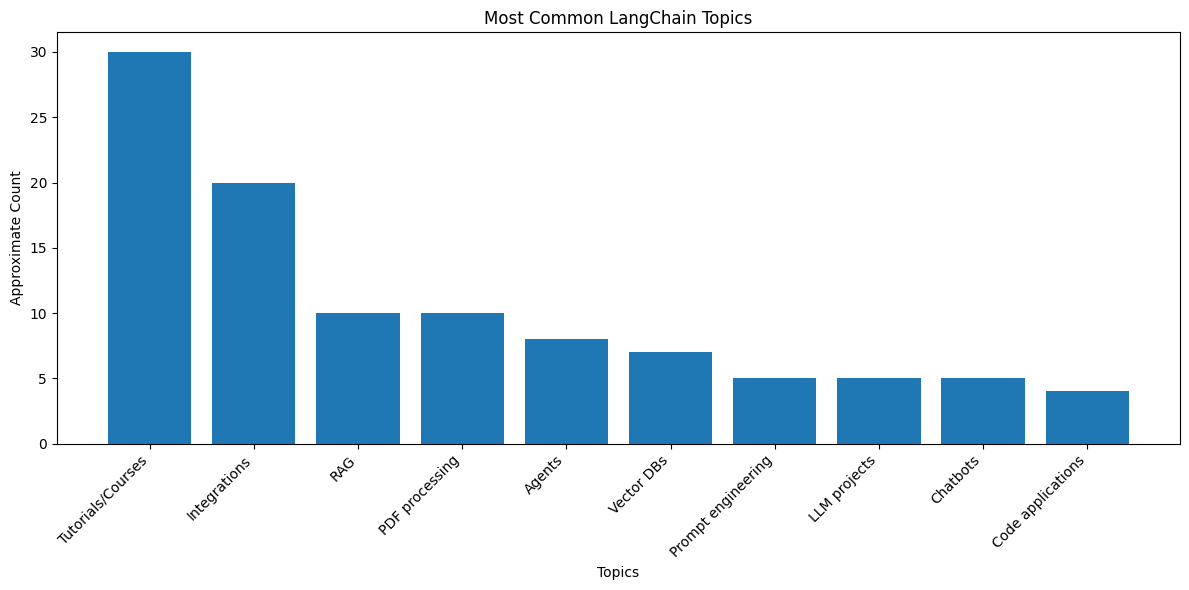

In [15]:
result = code_interpreter_results[0]
print(result)

result